In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# 1. Load dataset
df = pd.read_csv('Housing.csv')

df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


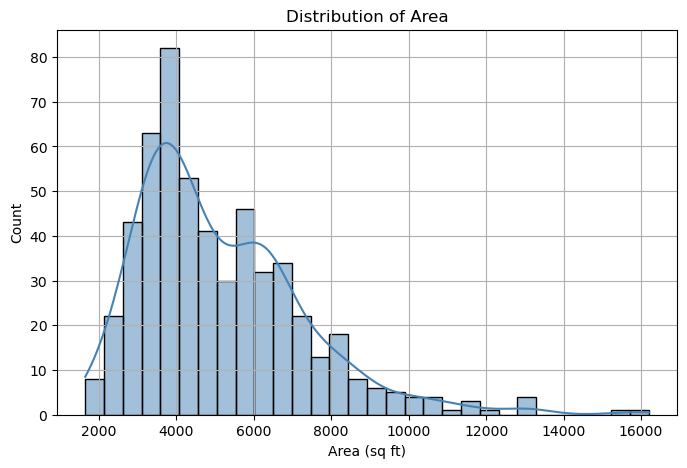

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['area'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Area")
plt.xlabel("Area (sq ft)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


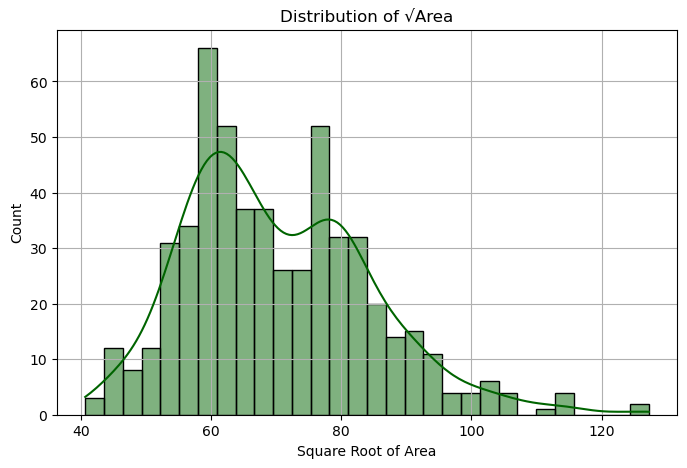

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute square root safely
df = df[df['area'] >= 0].copy()
df['area_sqrt'] = np.sqrt(df['area'])

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(df['area_sqrt'].dropna(), bins=30, kde=True, color='darkgreen')
plt.title("Distribution of √Area")
plt.xlabel("Square Root of Area")
plt.ylabel("Count")
plt.grid(True)
plt.show()



In [4]:
# 2. Create price_per_sqft feature (avoid division by zero)
df['price_per_sqft'] = df['price'] / df['area'].replace(0, np.nan)



In [5]:
# 3. One-hot encode furnishingstatus fully, drop first to avoid dummy trap
if 'furnishingstatus' in df.columns:
    df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)




In [6]:
# 4. Convert yes/no binaries in amenity columns to 0/1
binary_cols = [
    "mainroad",
    "guestroom",
    "basement",
    "hotwaterheating",
    "airconditioning",
    "prefarea",
]

for col in binary_cols:
    if df[col].dtype == object:
        df[col] = df[col].map({'yes': 1, 'no': 0})



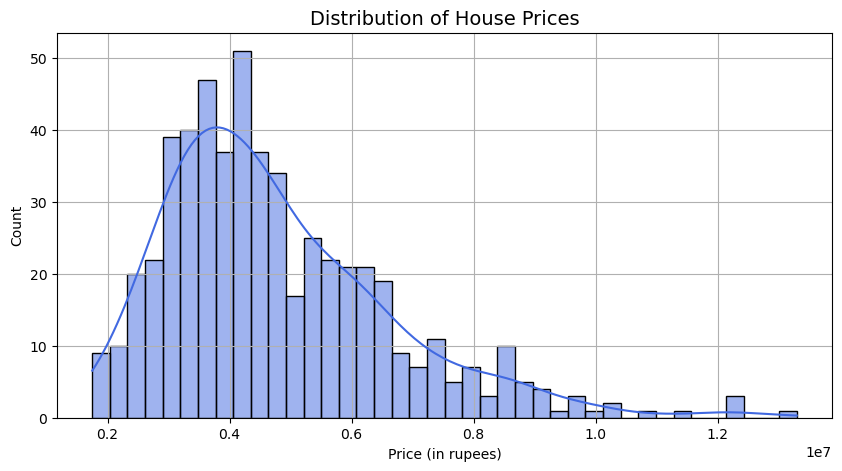

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot original price distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=40, kde=True, color='royalblue')
plt.title('Distribution of House Prices', fontsize=14)
plt.xlabel('Price (in rupees)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [8]:
# 5. Feature engineering

# Target transform
df["price_log"] = np.log(df["price"])

# Ratios/density features
df["area_per_bed"] = df["area"] / df["bedrooms"].replace(0, 1)
df["bath_per_bed"] = df["bathrooms"] / df["bedrooms"].replace(0, 1)
df["parking_per_bed"] = df["parking"] / (df["bedrooms"] + 1)

# Amenity count
df["amenity_count"] = df[binary_cols].sum(axis=1)

# Interaction terms
df["area_pref"] = df["area"] * df["prefarea"]
df["area_ac"] = df["area"] * df["airconditioning"]

# Low order polynomial
df["area_sqrt"] = np.sqrt(df["area"])



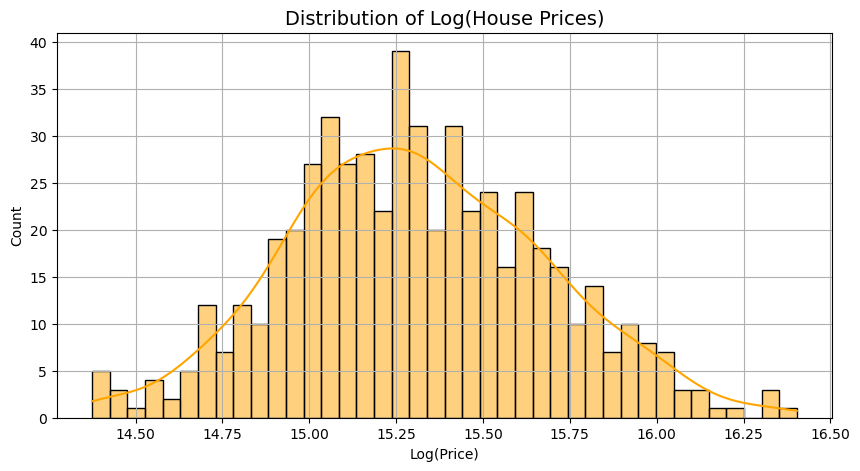

In [9]:
# Plot log(price) distribution
plt.figure(figsize=(10, 5))
sns.histplot(np.log(df['price']), bins=40, kde=True, color='orange')
plt.title('Distribution of Log(House Prices)', fontsize=14)
plt.xlabel('Log(Price)')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [10]:
# 6. Define features and target
TARGET = "price_log"
drop_cols = ["price", TARGET]
X = df.drop(columns=drop_cols)
y = df[TARGET]


In [11]:

# 7. Convert bool columns to int
for col in X.select_dtypes("bool"):
    X[col] = X[col].astype(int)


In [12]:
df.sample(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,...,price_per_sqft,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,price_log,area_per_bed,bath_per_bed,parking_per_bed,amenity_count,area_pref,area_ac
381,3605000,4000,2,1,1,1,0,0,0,0,...,901.250000,True,False,15.097832,2000.0,0.500000,0.000000,2,4000,0
202,4900000,4120,2,1,1,1,0,1,0,0,...,1189.320388,True,False,15.404746,2060.0,0.500000,0.333333,2,0,0
59,7210000,6000,3,2,4,1,1,0,0,1,...,1201.666667,False,False,15.790980,2000.0,0.666667,0.250000,3,0,6000
47,7490000,6600,3,1,4,1,0,0,0,1,...,1134.848485,False,False,15.829079,2200.0,0.333333,0.750000,3,6600,6600
412,3430000,2610,3,1,2,1,0,1,0,0,...,1314.176245,False,True,15.048071,870.0,0.333333,0.000000,3,2610,0


In [13]:

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:

# 9. Build pipeline: scale + linear regression
numeric_features = X.columns

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder="drop",
)

model = Pipeline(
    steps=[
        ("prep", preprocessor),
        ("linreg", LinearRegression()),
    ]
)



In [15]:
# 10. Cross-validated score on training data
cv_r2 = cross_val_score(
    model, X_train, y_train, cv=50, scoring="r2"
)
print(f"10-fold CV R² (train set): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")



10-fold CV R² (train set): 0.9228 ± 0.0988


In [16]:
# 11. Fit and evaluate on test
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred = np.exp(y_pred_log)
y_test_rup = np.exp(y_test)

r2 = r2_score(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test_rup, y_pred))




In [17]:

# 12. Sample predictions peek
sample = pd.DataFrame({
    "Actual_price": y_test_rup.values,
    "Predicted_price": y_pred,
}).head(10)
print(f"Hold-out R² (log-space): {r2:.4f}")
print(f"Hold-out RMSE (rupees): {rmse:,.0f}")
print("\nSample predictions:")
print(sample.to_string(index=False, formatters={
    "Actual_price": "{:,.0f}".format,
    "Predicted_price": "{:,.0f}".format,
}))

Hold-out R² (log-space): 0.9673
Hold-out RMSE (rupees): 429,007

Sample predictions:
Actual_price Predicted_price
   4,060,000       4,104,544
   6,650,000       6,749,063
   3,710,000       3,557,821
   6,440,000       6,327,464
   2,800,000       2,924,722
   4,900,000       4,733,102
   5,250,000       5,474,894
   4,543,000       4,516,236
   2,450,000       2,423,970
   3,353,000       3,224,053


In [18]:
model.predict([[7500,4,2,2,1,0,1,0,1,3,1,2]])	

ValueError: X has 12 features, but ColumnTransformer is expecting 21 features as input.